## Predictive Model for Water Level of the Chattooga River

TODO: ADD Image of the model here

As a whitewater kayaker, I take many trips to the Chattooga River. The water level is determined by the amount of rainfall in the area. It is important to know the water level of the river before making the trip, because if the water level is too high or too low, the river is not safe to take trips out. The goal of this project is to create a predictive model for the water level of the Chattooga River. This model will be used to predict the water level of the river for the next 24 hours. This will allow for an exploration of how predictive models work, using research to solve a problem, and provide a useful tool for me.

## Data Collection

Data collection consited of two parts, the water level and the percipitation data. This was a complicated process, and because I iterated on what data I wanted to use (precip -> humidity, etc.), I had to data collection through all parts of the project. This consisted of scraping the data from the web, cleaning it, and then storing it in a csv file. I also wrote code to periodically pull data from forcasts and history so that I could simulate how the model would actually predict data. 

#### Water Level

The first part was collecting data from the USGS site. The USGS website contained data only back to 2007, which is a limiting factor, but it is the best data available for the Chattooga River. The data would specfically be take from one site, Chattooga River Near Clayton, GA, since this is the one most often used by us kayakers. Data is in the form of a text file, listing data about water levels every 15 min. Since this interval is much faster than the other intervals, I decided to simplify the data by taking an average over the hour, which is the smallest interval I could get for weather data. The data is in ft, which does make the data a little less accurate, but this is an area where I can improve the model in the future.

#### Weather Data

The second part of the data is the weather data. Rabun county was used as it is the location of the gauge we are using for the Chattooga River. The data was in the form of a csv, and contained data from 2007 to 2023, and contains data about weather pulled every day. Originally, data was gathered from the weather [climate.gov](https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table), but this data only was every day, and the hourly/15 minute data only went back to 2014. I decided to look other places and found weather underground. While trying to use webscraping, I found they lazily loaded in their data from an api call, so I found the fetch request, took a look at the api it was using and found it was IBM's weather api. I wrote a script to pull all the hourly data from the api, and then wrote a script to clean the data and store it in a csv file, combining it with the water level data so I could pull this in instantly when I needed it.

## Data Processing

Once the data is gathered, I want to get a better understanding of what I am working with. Using pandas, we import the data from our csv and plot it. All data was also cleaned in the previous step (when I pulled it) to ensure that there are no missing values.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132256 entries, 2007-10-05 01:00:00 to 2023-05-29 17:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    132256 non-null  float64
 1   water   132256 non-null  float64
dtypes: float64(2)
memory usage: 3.0 MB


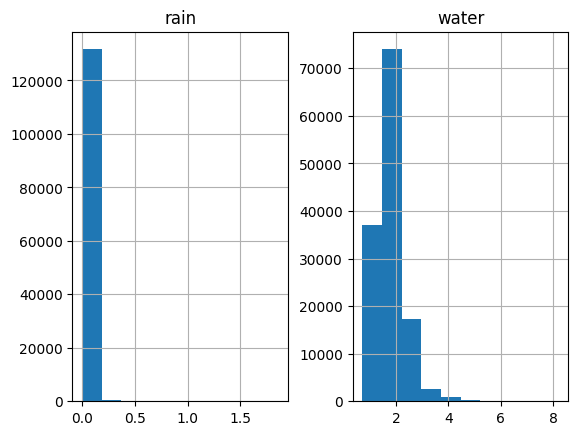

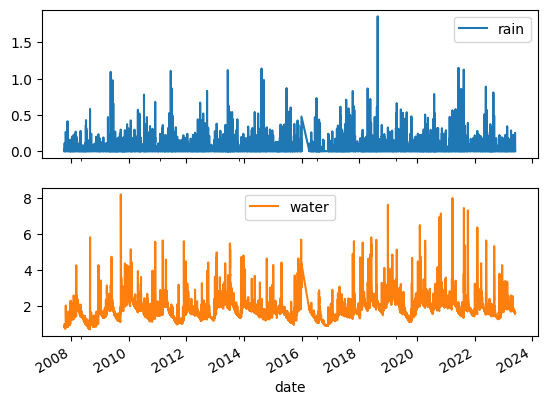

In [2]:
# This is the main file that will be used to run the project. Data pre-processing code can be seen in code/data-processing.py and code/scrape-precip-data.py
data = pd.read_csv('./data/combined_data.csv', parse_dates=['date'], index_col='date')

data.info()
data.hist()

# Plot the merged data (water level and precipitation)
data.plot(subplots=True)
plt.show()

In [93]:
X = data.drop(['water'], axis=1)
y = data['water']

# COuld do this programatically but this is an 80/20 split
train_data = data.loc['2007-10-05 01:00:00':'2020-05-09 14:00:00']
test_data = data.loc['2020-05-09 14:00:00':]

train_X = train_data.drop(['water'], axis=1)
train_y = train_data['water']

test_X = test_data.drop(['water'], axis=1)
test_y = test_data['water']

These are partial autocorrelation functions, and are used to help me visualize lag time and how coupled my data is (from my understnading). By looking at the graph, it appears data is mostly relavant roughly 3 days after the inital value

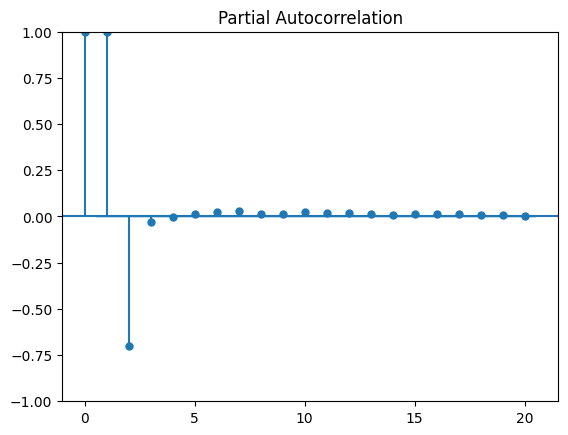

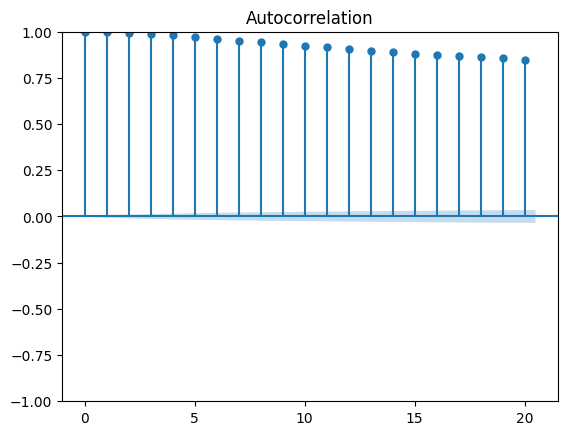

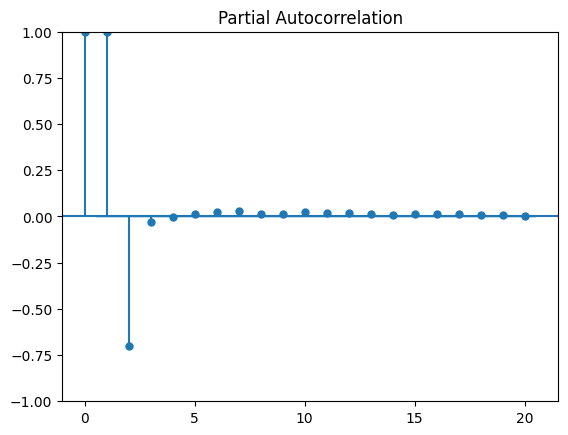

In [6]:
plot_acf(train_data['water'], lags=20)
plot_pacf(train_data['water'], lags=20)

### LSTM- Version 1

![LSTM Model](pics/LSTM1.png)

#### Background
This was the first model where I had a breakthrough. I was able to get the model to work, and it was able to predict the water level of the river. However, it was not very accurate, and I was not able to get it to work with the data I wanted to use. The biggest issue is with the way the model works, or at least the way I could get it to work. It needed some context of what the water level is, so I passed it historical data of the water level, with a delay of the prediction length. The issue is the only prediction length of a meaningful time i could get to work was 4 hours. This means that the model could only predict 4 hours into the future. This is not very useful, as I want to be able to predict 24 hours into the future. Lets explore this model, how I can improve it, and why it is not very useful.

##### Data



TODO: 
1. Add in the reasoning for using LSTM (papers etc)
2. Clean up the code and remove all variable that are ...2 (this is the second iteration of the code)
3. Optomize the values to try and get to at least 0.85 if possible
4. This code is just wrong. It uses the water level, not the precip data. Rework, i think i understand it better.

In [385]:
# Set up the LSTM model
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# Number of hours of data to use to predict the next hour
sequence_length = 24
# Number of hours to predict
prediction_length = 4

# Normalie the data between 0 and 1 with min max scaler so we can undo it later
water_scaler = MinMaxScaler(feature_range=(0, 1))
rain_scaler = MinMaxScaler(feature_range=(0, 1))
water_scaled_data = water_scaler.fit_transform(data['water'].values.reshape(-1, 1))
rain_scaled_data = rain_scaler.fit_transform(data['rain'].values.reshape(-1, 1))

# scaled data split between train and test with the 80/20 split
water_scaled_train_data = water_scaled_data[:int(0.8 * len(data))]
water_scaled_test_data = water_scaled_data[int(0.8 * len(data)):]

rain_scaled_train_data = rain_scaled_data[:int(0.8 * len(data))]
rain_scaled_test_data = rain_scaled_data[int(0.8 * len(data)):]

# Reshape data to be sequences of sequence_length days
def create_sequences(rain_data, water_data, sequence_length):
    xs = []
    ys = []

    for i in range((sequence_length + prediction_length), len(water_data)):
        water_subsequence = water_data[(i - sequence_length - prediction_length):i-prediction_length]
        rain_subsequence = rain_data[(i - sequence_length):i]
        x = np.column_stack((water_subsequence, rain_subsequence))
        y = water_data[i]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

train_X, train_y = create_sequences(rain_scaled_train_data, water_scaled_train_data, sequence_length)
print(train_X.shape)
print(train_y.shape)

# Initalize the model. It is a multi layer model, with an LSTM layer and a dense layer
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(sequence_length, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

test_X2, test_y2 = create_sequences(rain_scaled_test_data, water_scaled_test_data, sequence_length)
loss = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X2, test_y2), verbose=2, shuffle=False)

(105776, 24, 2)
(105776, 1)
Epoch 1/10
3306/3306 - 9s - loss: 9.7591e-04 - val_loss: 8.6107e-04 - 9s/epoch - 3ms/step
Epoch 2/10
3306/3306 - 9s - loss: 4.1392e-04 - val_loss: 6.3878e-04 - 9s/epoch - 3ms/step
Epoch 3/10
3306/3306 - 9s - loss: 3.5302e-04 - val_loss: 5.3501e-04 - 9s/epoch - 3ms/step
Epoch 4/10
3306/3306 - 9s - loss: 2.9652e-04 - val_loss: 4.3717e-04 - 9s/epoch - 3ms/step
Epoch 5/10
3306/3306 - 9s - loss: 2.6666e-04 - val_loss: 3.8376e-04 - 9s/epoch - 3ms/step
Epoch 6/10
3306/3306 - 9s - loss: 2.4231e-04 - val_loss: 3.5835e-04 - 9s/epoch - 3ms/step
Epoch 7/10
3306/3306 - 9s - loss: 2.2068e-04 - val_loss: 3.6837e-04 - 9s/epoch - 3ms/step
Epoch 8/10
3306/3306 - 9s - loss: 2.0599e-04 - val_loss: 3.3276e-04 - 9s/epoch - 3ms/step
Epoch 9/10
3306/3306 - 9s - loss: 2.0339e-04 - val_loss: 3.2922e-04 - 9s/epoch - 3ms/step
Epoch 10/10
3306/3306 - 9s - loss: 1.9205e-04 - val_loss: 3.1595e-04 - 9s/epoch - 3ms/step


826/826 [==============================] - 1s 795us/step
                     Predicted  Actual
date                                  
2020-05-10 20:00:00   2.049731  2.0900
2020-05-10 21:00:00   2.043367  2.0900
2020-05-10 22:00:00   2.041610  2.0900
2020-05-10 23:00:00   2.041829  2.0900
2020-05-11 00:00:00   2.040334  2.0900
...                        ...     ...
2023-05-29 13:00:00   1.643854  1.6500
2023-05-29 14:00:00   1.643820  1.6450
2023-05-29 15:00:00   1.644230  1.6400
2023-05-29 16:00:00   1.638430  1.6375
2023-05-29 17:00:00   1.634369  1.6300

[26424 rows x 2 columns]
R^2: 0.9240216887963437


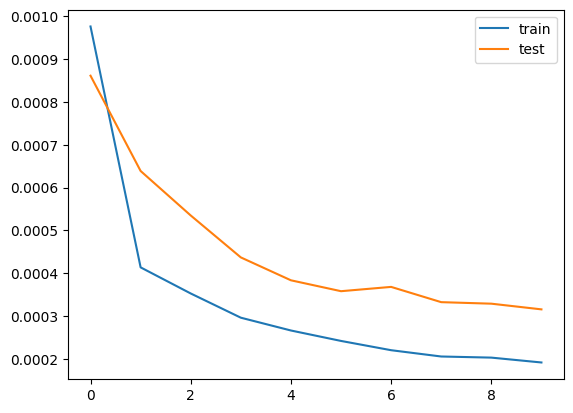

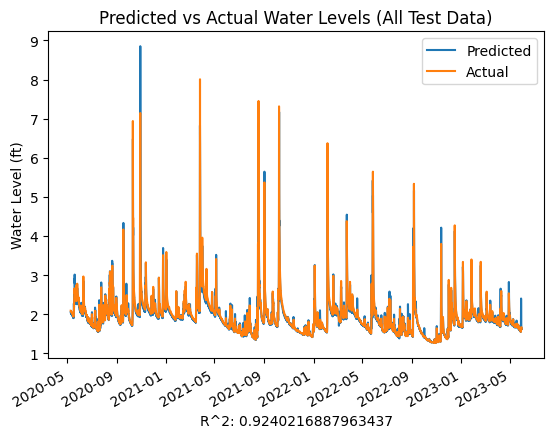

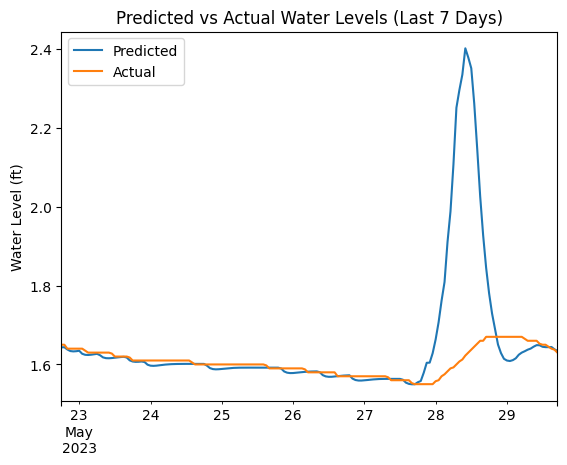

In [391]:
# Plot the loss
pyplot.plot(loss.history['loss'], label='train')
pyplot.plot(loss.history['val_loss'], label='test')
pyplot.legend()

predicted_values = model.predict(test_X2)
predicted_values = water_scaler.inverse_transform(predicted_values)
predicted_values -= 0.06 # For some reason the data seems high, gonna augment it a bit

# Using drop() function to delete last 10 rows so that the sizes match
test_data2 = test_data.copy()
test_data2.drop(test_data.head(sequence_length+prediction_length+2).index, inplace=True) 

predictions_df = pd.DataFrame({'Predicted': predicted_values.flatten(), 'Actual': test_data2['water']})

print(predictions_df)

predictions_df.plot(title='Predicted vs Actual Water Levels (All Test Data)', xlabel='R^2: 0.9240216887963437', ylabel='Water Level (ft)')

ten_day = predictions_df.tail(168)

ten_day.plot(title='Predicted vs Actual Water Levels (Last 7 Days)', xlabel='', ylabel='Water Level (ft)')

# Calculate the R-squared value
print("R^2:", r2_score(test_data2['water'], predicted_values.flatten()))

## Next Steps
1. Rework LSTM to use more data such as humidity
2. Eleminate odd spikes in data
3. 

### WIP- Everything below here is a work in progress

In [272]:
# Make a 4 hour prediction
prediction_data = pd.read_csv('./data/prediction.csv', parse_dates=['date'], index_col='date')
# print(prediction_data)

test_data_copy = test_data.copy()

def create_sequence(data, sequence_length):
    xs = []

    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        xs.append(x)

    return np.array(xs)

prediction_sequences = create_sequence(prediction_data['rain'].values.reshape(-1, 1), sequence_length)
test_data_and_prediction = np.concatenate((test_data_copy, prediction_sequences), axis=0)
print(test_data_and_prediction.shape)
predicted_values_week = model.predict(test_data_and_prediction)
predicted_values_week = water_scaler.inverse_transform(predicted_values_week)

# Plot the 10 day forecast
print(predicted_values_week.flatten().shape)
predictions_df = pd.DataFrame({'Predicted': predicted_values_week.flatten()[-200:]})
predictions_df.plot()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [4]:
# Define the ARIMA model parameters
p = 1  # AR order
d = 1  # Integration order
q = 2  # MA order

# Create the ARIMA model
model = ARIMA(train_data['water'], order=(p, d, q))

# Fit the model to the training data, using the precipitation amount as an exogenous variable
model_fit = model.fit()

/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  water   No. Observations:               105803
Model:                 ARIMA(1, 1, 2)   Log Likelihood              242330.207
Date:                Thu, 22 Jun 2023   AIC                        -484652.414
Time:                        10:41:53   BIC                        -484614.137
Sample:                             0   HQIC                       -484640.827
                             - 105803                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7174      0.001    914.349      0.000       0.716       0.719
ma.L1         -0.0244      0.001    -31.431      0.000      -0.026      -0.023
ma.L2          0.0012      0.001      1.472      0.1

/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/brycejackson/Documents/GitHub/water-level-predictive-model/water-level-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

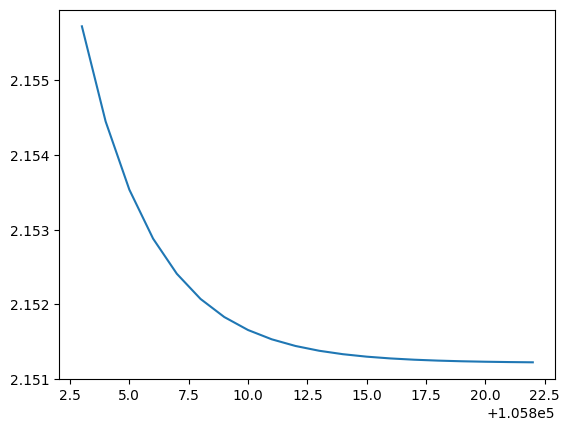

In [7]:
# Specify the start and end dates for prediction
start_date = test_data.index[0]
end_date = test_data.index[-1]

print(model_fit.summary())

# Generate predictions for the specified date range, usisng the precipitation amount as an exogenous variable
# predictions = model_fit.predict(start=start_date)

predictions = model_fit.forecast(20)

predictions

predictions.plot()

# mse = np.mean((predictions - test_data['water_level']) ** 2)

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

svm_model = SVR(kernel='rbf')

X_train = train_data['rain'].values.reshape(-1, 1)
y_train = train_data['water'].values

y_train

svm_model.fit(X_train, y_train)

X_test = test_data['rain'].values.reshape(-1, 1)
y_test = test_data['water'].values

y_pred = svm_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.3042227534315587
R-squared: -0.3315628092105727
